# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.optimize import curve_fit

from qiskit import *
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV1, Options

In [2]:
token = '' # Put in your IBM token
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite= True)

# Functions to write the Decoherence circuits

In [2]:
def new_observable(beta, a, b):
    def Rz(beta):
        return np.array([[np.cos(beta/2) - 1j * np.sin(beta/2), 0], [0, np.cos(beta/2) + 1j * np.sin(beta/2)]])
    
    I = np.array([[1, 0], [0, 1]])
    X = np.array([[0, 1], [1, 0]])
    Rzbeta = Rz(beta)
    Rzbetainv = Rz(-beta)
    T = a * I + b * X
    return T @ Rzbetainv @ X @ Rzbeta @ T

def eigs(beta, a, b):
    TOT = new_observable(beta, a, b)
    eigenvalues, eigenvectors = np.linalg.eig(TOT)
    eigvec0, eigvec1 = eigenvectors[:,0], eigenvectors[:,1]
    eigvec0 = eigvec0 / np.linalg.norm(eigvec0)
    eigvec1 = eigvec1 / np.linalg.norm(eigvec1)
    eigenvectors = (eigvec0, eigvec1)
    return eigenvalues, eigenvectors

def X_eigs(a, b):
    eigval0 = 2*a*b + (a**2 + b**2)
    eigval1 = 2*a*b - (a**2 + b**2)
    return eigval0, eigval1


def transform_basis(qc, beta, qubit, a, b):
    eigenvectors = eigs(beta, a, b)[1]
    eigvec0, eigvec1 = eigenvectors[0], eigenvectors[1]
    zero = np.array([1, 0])
    one = np.array([0, 1])
    U = np.outer(zero, eigvec0.conj()) + np.outer(one, eigvec1.conj())
    if beta == 0:
        sign = ""
    else:
        sign = beta/abs(beta)
    gate_label = "U(" + str(sign) + str(np.round(beta, 3)) + ")"
    qc.unitary(U, qubit, label = gate_label)

def twirled_cz(qc, qubit1, qubit2, repeats=1):
    """
    twirl is an integer in {0, 1, ... 15}, representing one of possible 16 Pauli twirls of {I, X, Y, Z}^{otimes 2} in 4-ary.
    repeats is some (odd) number for which the CZ is repeated.
    """
    for _ in range(repeats):
        twirl = np.random.randint(16)
        match twirl:
            case 0: # II
                qc.cz(qubit1, qubit2)

            case 1:
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)
                qc.x(qubit2)
            
            case 2:
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit2)

            case 3:
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)
                qc.y(qubit2)

            case 4:
                qc.x(qubit1)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)
                qc.z(qubit2)

            case 5:
                qc.x(qubit1)
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)
                qc.y(qubit2)

            case 6:
                qc.x(qubit1)
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)

            case 7:
                qc.x(qubit1)
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)
                qc.x(qubit2)

            case 8:
                qc.z(qubit1)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)

            case 9:
                qc.z(qubit1)
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit2)

            case 10:
                qc.z(qubit1)
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)
                qc.z(qubit2)

            case 11:
                qc.z(qubit1)
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit2)

            case 12:
                qc.y(qubit1)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)
                qc.z(qubit2)

            case 13:
                qc.y(qubit1)
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)
                qc.y(qubit2)

            case 14:
                qc.y(qubit1)
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)

            case 15:
                qc.y(qubit1)
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)
                qc.x(qubit2)

In [3]:
def eigs(beta, a, b):
    TOT = new_observable(beta, a, b)
    eigenvalues, eigenvectors = np.linalg.eig(TOT)
    eigvec0, eigvec1 = eigenvectors[:,0], eigenvectors[:,1]
    eigvec0 = eigvec0 / np.linalg.norm(eigvec0)
    eigvec1 = eigvec1 / np.linalg.norm(eigvec1)
    eigenvectors = (eigvec0, eigvec1)
    return eigenvalues, eigenvectors

def X_eigs(a, b):
    eigval0 = 2*a*b + (a**2 + b**2)
    eigval1 = 2*a*b - (a**2 + b**2)
    return eigval0, eigval1

In [4]:
# Functions for preparing + running COP circuits

def generate_circuit(beta, a, b, meas_last_x, repeats=1):
    """
    Generates one circuit corresponding to one measurement outcome of experiment we are trying to simulate.
    A cluster state is prepared, then a rotation is conducted on the third site. A state tomography measurement
    (either X or Y) is conducted on the last qubit. Post processing is done of outcomes to account for non-unitary T.
    Inputs: beta - Rotation angle
            a, b - Coefficients for the T tensor, which is a product of aI + bX.
            meas_last_x - Whether the fifth qubit is measured in the X basis or not
    Outputs: The circuit
    """
    # Initializes circuit
    qr = QuantumRegister(5)
    qc = QuantumCircuit(qr)

    qc.h(qr)
    # Creates 5-qubit chain
    twirled_cz(qc, 0, 1, repeats)
    twirled_cz(qc, 2, 3, repeats)
    twirled_cz(qc, 1, 2, repeats)
    twirled_cz(qc, 3, 4, repeats)
    
    # Measure qubits 1, 2, 4 in x basis
    qc.h(0)
    qc.h(1)
    qc.h(3)

    # Measure qubit 3 in rotated basis
    transform_basis(qc, beta, 2, a, b)
    
    # Measure last qubit in Y basis (or X basis)
    if meas_last_x == 0:
        qc.sdg(4)  
    qc.h(4)

    qc.measure_all()
    
    return qc

In [5]:
def generate_circuits(ab_ar, beta_ar):
    """
    Generates n circuits (one for each rotation angle)
    Inputs: beta_ar - array of rotation angles
            ab_ar - array of variational ansatz states
    Outputs: List of 2 * len(beta_ar) circuits
    """ 
    qc_list = []
    for ab in ab_ar:
        for beta in beta_ar:
            for meas_last_x in range(2):
                qc_list.append(generate_circuit(beta, ab[0], ab[1], meas_last_x))
    return qc_list

# Running the Decoherence Circuits

In [20]:
best_qubits = [29, 28, 27, 26, 25]

shots_num = 10000
# tan_beta_ar = np.linspace(0, 2, 10)
# beta_ar = np.arctan(tan_beta_ar)
beta_ar = np.linspace(0, np.pi, 17)

VQE_exp_data = np.load("processed_data/VQE_N5_thetamins_and_SOPs.npz")

alpha_ar = VQE_exp_data["alphas_exp"]
theta_ar = VQE_exp_data["thetamins_5_exp"]
ab_ar = [(np.cos(theta_ar[i]), np.sin(theta_ar[i])) for i in range(9)]
# Restrict to a couple curves we want to measure
alpha_ar = np.concatenate((np.array([alpha_ar[0], alpha_ar[4]]), alpha_ar[-3:]))
theta_ar = np.concatenate((np.array([theta_ar[0], theta_ar[4]]), theta_ar[-3:]))
ab_ar = np.concatenate((np.array([ab_ar[0], ab_ar[4]]), ab_ar[-3:]))

In [7]:
service = QiskitRuntimeService()
backend = service.backend("ibm_quebec")

In [73]:
with Session(service=service, backend=backend, max_time="90m") as session:
    options = Options()
    options.resilience_level = 1  # Set level of error mitigation
    options.optimization_level = 0  # Set optimization level
    sampler = SamplerV1(session=session, options=options)  # Note that SamplerV1 is soon deprecated
    print(session.details())
    print(session.status())

    qc_list = transpile(generate_circuits(ab_ar_restricted, beta_ar), backend=backend, initial_layout=best_qubits)
    job_exp_1 = sampler.run(qc_list, shots=shots_num)
    print(session.status())

    # Add more jobs as necessary to session

{'id': 'ctd93tqakxxg008mrq70', 'backend_name': 'ibm_quebec', 'interactive_timeout': 60, 'max_time': 5400, 'active_timeout': 5400, 'state': 'open', 'accepting_jobs': True, 'last_job_started': None, 'last_job_completed': None, 'started_at': None, 'closed_at': None, 'activated_at': None}
Pending
Pending
In progress, accepting new jobs
In progress, accepting new jobs
In progress, accepting new jobs
In progress, accepting new jobs
In progress, accepting new jobs
In progress, accepting new jobs
In progress, accepting new jobs


# Post-Processing Data

In [13]:
def decimal_to_bin(base10):
    zero_dig = str(base10 // 2**0 % 2)
    one_dig = str(base10 // 2**1 % 2)
    two_dig = str(base10 // 2**2 % 2)
    three_dig = str(base10 // 2**3 % 2)
    four_dig = str(base10 // 2**4 % 2)
    return four_dig + three_dig + two_dig + one_dig + zero_dig

def convert_to_counts(quasi_dist_dict, shots):
    count_dict = {}
    for key, val in quasi_dist_dict.items():
        count_dict[decimal_to_bin(int(key))] = val * shots
    return count_dict

In [14]:
def convert_bin(s):
    if s == 0:
        return 1
    else:
        return -1

def expectation(counts, beta, a, b, meas_last_x):
    states = counts.keys()
    exp_val = 0
    total_counts = 0
    for state in states:
        count = counts.get(state)
        s0 = convert_bin(int(state[-1]))
        # s1 = int(state[-2])
        s2 = int(state[-3])
        s3 = int(state[-4])
        s4 = convert_bin(int(state[-5]))

        s2 = eigs(beta, a, b)[0][s2]
        s3 = X_eigs(a, b)[s3]

        if meas_last_x == 1:
            s3 = 1
        
        exp_val += s0 * s2 * s3 * s4 * count
        # Byproduct operator from s1 is absorbed into the initial |+> state and hence irrelevant.
        # If we perform a logical measurement X, the byproduct from s3 commutes through and therefore irrelevant.
        total_counts += count

    return np.real(exp_val) / total_counts

def post_process_results(counts_list, beta_ar, ab_ar):
    """
    Inputs: counts_list - measurement outcomes from two circuits
    beta - rotation angle
    a, b - Parameters for T.

    Outputs:Yavg, Xavg
    """
    Y_results = []
    X_results = []
    exp_num = 0
    for ab in ab_ar:
        for beta in beta_ar:
            Y_results.append(expectation(counts_list[exp_num], beta, ab[0], ab[1], 0))
            X_results.append(expectation(counts_list[exp_num+1], beta, ab[0], ab[1], 1))
            exp_num += 2
    return Y_results, X_results

In [10]:
job_names = ["ctd94fsvdgb0008zhgj0", "ctd955cakxxg008mrqeg", "ctd95tqvdgb0008zhh2g", "ctd96fs1zwrg008cc4n0", "ctd975cakxxg008mrr30", "ctd97vfy6ybg008fb3ng", "ctd98gjy6ybg008fb3s0", "ctd995wakxxg008mrrpg"] 

In [15]:
# Extract quasi_probability distribution dictionaries from files

quasi_dist_list_across_repeats = []
for job_name in job_names:
    f = open("raw_data/Decoherence_" + job_name + ".json")
    quasi_dist_f = json.load(f)
    quasi_dist_list_across_repeats.append(quasi_dist_f)
    f.close()

In [16]:
# Convert quasi-probability distributions to counts

counts_list_across_repeats = []
for run in quasi_dist_list_across_repeats:
    counts_list = []
    for i in range(len(run)):
        counts_list.append(convert_to_counts(run[i], shots_num))
    counts_list_across_repeats.append(counts_list)

In [21]:
# Compute <Y>, <X>

Y_ars = []
X_ars = []
for counts_list in counts_list_across_repeats:
    Y_ar, X_ar = post_process_results(counts_list, beta_ar, ab_ar)
    Y_ars.append(Y_ar)
    X_ars.append(X_ar)

In [22]:
# Compute means and standard error of means for <X>, <Y> across repeats
Y_ar_mean = []
Y_ar_std = []
X_ar_mean = []
X_ar_std = []

for j in range(len(Y_ars[0])):
    Y_ar = []
    X_ar = []
    for i in range(len(Y_ars)):
        Y_ar.append(Y_ars[i][j])
        X_ar.append(X_ars[i][j])
    Y_ar = np.array(Y_ar)
    X_ar = np.array(X_ar)

    Y_ar_mean.append(np.mean(Y_ar))
    Y_ar_std.append(np.std(Y_ar)/np.sqrt(len(Y_ar)))
    X_ar_mean.append(np.mean(X_ar))
    X_ar_std.append(np.std(X_ar)/np.sqrt(len(X_ar)))

Y_ar_mean = np.array(Y_ar_mean)
Y_ar_std = np.array(Y_ar_std)
X_ar_mean = np.array(X_ar_mean)
X_ar_std = np.array(X_ar_std)

In [23]:
for i in [0, 4, 6, 7, 8]:
    np.savez('processed_data/Decoherence_alpha' + str(i) + 'pi16_YXs.npz', beta_ar=beta_ar, Y_ar_mean=Y_ar_mean[i * len(beta_ar):(i+1) * len(beta_ar)], Y_ar_std=Y_ar_std[i * len(beta_ar):(i+1) * len(beta_ar)], X_ar_mean=X_ar_mean[i * len(beta_ar):(i+1) * len(beta_ar)], X_ar_std=X_ar_std[i * len(beta_ar):(i+1) * len(beta_ar)])

# Plotting Results and Extracting Computational Order Parameters

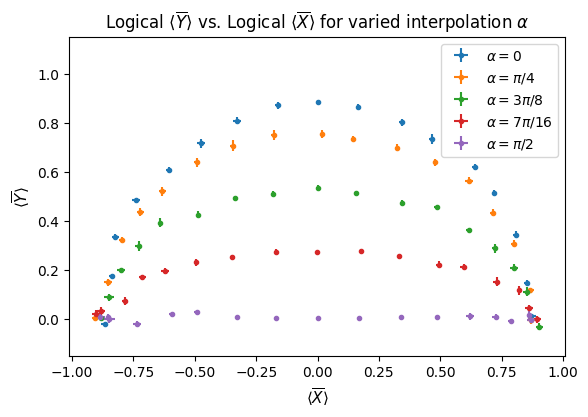

In [33]:
plt.errorbar(X_ar_mean[17*0: 17*1], Y_ar_mean[17*0: 17*1], xerr= X_ar_std[17*0:17*1], yerr = Y_ar_std[17*0:17*1], fmt=".", label=r"$\alpha=0$")
plt.errorbar(X_ar_mean[17*1: 17*2], Y_ar_mean[17*1: 17*2], xerr= X_ar_std[17*1:17*2], yerr = Y_ar_std[17*1:17*2], fmt=".", label=r"$\alpha=\pi/4$")
plt.errorbar(X_ar_mean[17*2: 17*3], Y_ar_mean[17*2: 17*3], xerr= X_ar_std[17*2:17*3], yerr = Y_ar_std[17*2:17*3], fmt=".", label=r"$\alpha=3\pi/8$")
plt.errorbar(X_ar_mean[17*3: 17*4], Y_ar_mean[17*3: 17*4], xerr= X_ar_std[17*3:17*4], yerr = Y_ar_std[17*3:17*4], fmt=".", label=r"$\alpha=7\pi/16$")
plt.errorbar(X_ar_mean[17*4: 17*5], Y_ar_mean[17*4: 17*5], xerr= X_ar_std[17*4:17*5], yerr = Y_ar_std[17*4:17*5], fmt=".", label=r"$\alpha=\pi/2$")
plt.title(r"Logical $\langle \overline{Y} \rangle$ vs. Logical $\langle \overline{X} \rangle$ for varied interpolation $\alpha$", size=12)
plt.legend(fontsize=10, loc="best")
plt.ylabel(r"$\langle \overline{Y} \rangle$", size=11)
plt.xlabel(r"$\langle \overline{X} \rangle$", size=11)

plt.axis('scaled')
plt.ylim(-0.15, 1.15)
plt.savefig("figures/decoherence_ellipses.pdf")